# Import necessary libraries

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import os
from pathlib import Path
import json

import numpy as np 
import pandas as pd
import math

import warnings
warnings.filterwarnings('ignore')

import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 10
plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
from PIL import Image

from collections import Counter
from collections import defaultdict

import keras
from keras.layers import *
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing import image

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
import tensorflow_addons as tfa
from tensorflow_addons.activations import mish
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/kaggle/steel_defect_detection'

/content/drive/My Drive/kaggle/steel_defect_detection


In [ ]:
train_df = pd.read_csv("train.csv")
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


# Calculating Pixel counts as a new feature

In [ ]:
def pixel_count(i):
    '''
    Input: EncodedPixels (str)
    Output: number of pixels having the defect
    '''
    return sum([int(k) for k in i.split(' ')[1::2]])

In [ ]:
DEFECT_TYPES = [1, 2, 3, 4]

for x in DEFECT_TYPES:
    train_df.loc[train_df.ClassId==x, 'pixel_count'] = train_df.loc[train_df.ClassId==x, 'EncodedPixels'].apply(pixel_count) 

pixel_count = train_df['pixel_count']
train_df.head()

,ImageId,ClassId,EncodedPixels,pixel_count
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,4396.0
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,6897.0
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,8319.0
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,69357.0
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,4851.0


******DEFECT TYPE 1*****
count      897.000000
mean      4361.347826
std       3591.053407
min        163.000000
25%       1762.000000
50%       3326.000000
75%       5795.000000
max      31303.000000
Name: pixel_count, dtype: float64


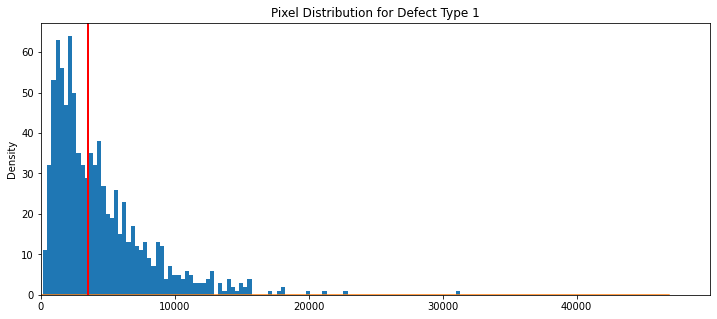

******DEFECT TYPE 2*****
count      247.000000
mean      3378.425101
std       2049.382114
min        316.000000
25%       1947.500000
50%       2944.000000
75%       4337.500000
max      14023.000000
Name: pixel_count, dtype: float64


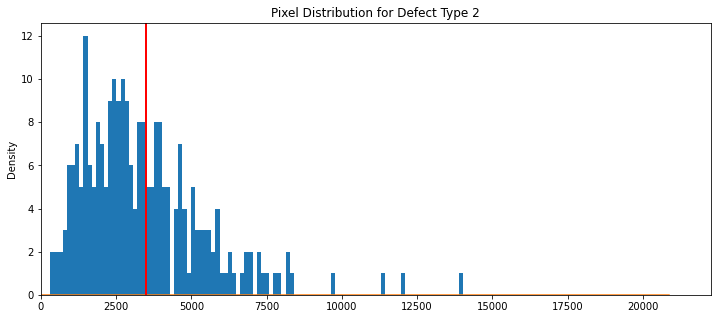

******DEFECT TYPE 3*****
count      5150.000000
mean      25496.485243
std       37945.334103
min         115.000000
25%        5054.250000
50%       11953.500000
75%       29029.500000
max      368240.000000
Name: pixel_count, dtype: float64


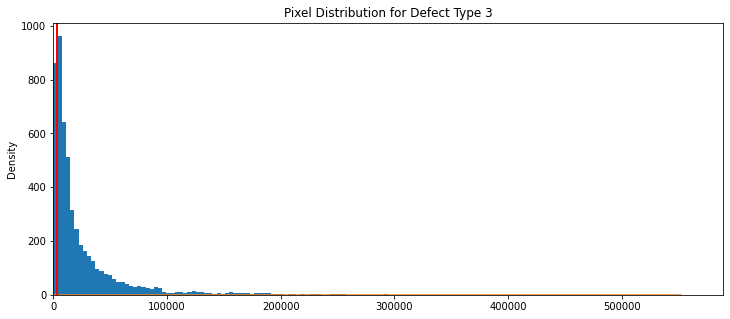

******DEFECT TYPE 4*****
count       801.000000
mean      34373.997503
std       29590.265099
min         491.000000
25%       13114.000000
50%       25357.000000
75%       45221.000000
max      192780.000000
Name: pixel_count, dtype: float64


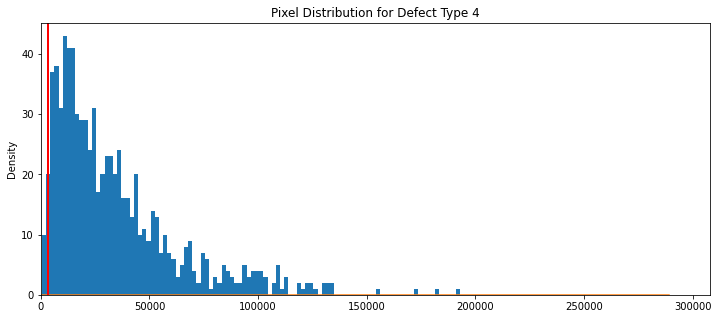

In [ ]:
for x in DEFECT_TYPES:
    df = train_df.loc[train_df.ClassId==x, :]
    ax = df['pixel_count'].plot(kind='hist', bins=100, figsize=(12, 5))
    df['pixel_count'].plot(kind='kde', ax=ax)
    plt.xlim(left=0)
    plt.axvline(x=3500, linewidth=2, color='r')
    plt.title(f'Pixel Distribution for Defect Type {x}')
    print(f'******DEFECT TYPE {x}*****')
    print(df['pixel_count'].describe())
    plt.show()

In [ ]:
THRESHOLDS = []

for x in DEFECT_TYPES:
    pixels = train_df.loc[train_df['ClassId']==x, 'pixel_count']
    threshold = np.nanquantile(pixels, 0.1)
    THRESHOLDS.append(int(threshold))
    print(f'Quantile threshold for defect type {x} = {int(threshold)}')

Quantile threshold for defect type 1 = 1062
Quantile threshold for defect type 2 = 1212
Quantile threshold for defect type 3 = 2785
Quantile threshold for defect type 4 = 7090


In [ ]:
THRESHOLDS[3] = 3500

In [ ]:
THRESHOLDS

[1062, 1212, 2785, 3500]

In [ ]:
train_df['fname'], train_df['cls'] = train_df['ImageId'], train_df['ClassId']
train_df['cls'] = train_df['cls'].astype(int)
train_df = train_df.pivot(index='fname',columns='cls', values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)
train_df.head()

cls,1,2,3,4,defects
fname,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1


# EDA

In [ ]:
# Presence of defects in each images
no_defects_num = np.sum(train_df['defects'] == 0)
defects_num = len(train_df) - no_defects_num
print("no_defect imgs \t:", no_defects_num)
print("defects imgs \t:", defects_num)

no_defect imgs 	: 0
defects imgs 	: 6666


In [ ]:
# Number of defects for each class
class_defects = len(train_df) - train_df.isnull().sum() 
class_defects

cls
1           897
2           247
3          5150
4           801
defects    6666
dtype: int64

Text(0.5, 0, 'class')

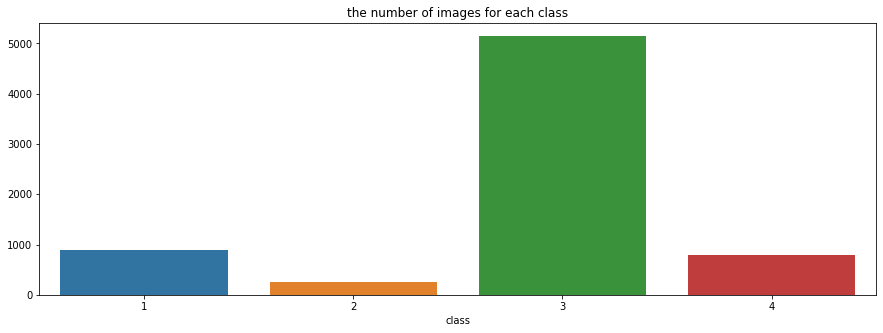

In [ ]:
cls = [1, 2, 3, 4]
no_of_defects = []

for i in range(1, len(class_defects)):
    no_of_defects.append(class_defects[i])
    
fig, ax = plt.subplots()
sns.barplot(x=cls , y=no_of_defects , ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")

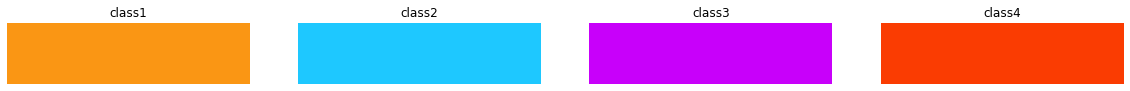

In [ ]:
palet = [(250, 150, 20), (30, 200, 255), (200, 0, 250), (250, 60, 2)]

fig, ax = plt.subplots(1, 4, figsize=(20, 25))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((20, 80, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title(f"class{i+1}")

plt.show()

In [ ]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):     # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [ ]:
def createMask(row_id):
    """
    row_id: index corresponding to image name in train_df; say for row_id = 1
    imgId: 0007a71bf.jpg
    en_pixels =   cls
                1                                                  NaN
                2                                                  NaN
                3    18661 28 18863 82 19091 110 19347 110 19603 11...
                4                                                  NaN
    en_pixels.values = array([nan, nan, '18661 28 18863 82 19091 110 19347 110 19603 11...', nan]
    """
    imgId = train_df.iloc[row_id].name  

    en_pixels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)     # 4 channels corresponding to the 4 defects

    for idx, en_pix in enumerate(en_pixels.values):
        if en_pix is not np.nan:
            en_pix = en_pix.split(" ")
            pixel_start = map(int, en_pix[0::2])
            pixel_length = map(int, en_pix[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for start, length in zip(pixel_start, pixel_length):
                mask[start:(start + length)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
            
    return imgId, masks

In [ ]:
def showMasks(row_id, contour = True):
    imgId, mask = createMask(row_id)
    img = cv2.imread(imgId)

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title(imgId)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [ ]:
# anonymous lambda function syntax - lambda arguments: expression
# classify defects
idx_class_1 = list(filter(lambda r:not pd.isna(train_df.iloc[r,0]), range(len(train_df))))
idx_class_2 = list(filter(lambda r:not pd.isna(train_df.iloc[r,1]), range(len(train_df))))
idx_class_3 = list(filter(lambda r:not pd.isna(train_df.iloc[r,2]), range(len(train_df))))
idx_class_4 = list(filter(lambda r:not pd.isna(train_df.iloc[r,3]), range(len(train_df))))

# Number of defects class
idx_1_defect = list(filter(lambda r:train_df.iloc[r,4] == 1, range(len(train_df))))
idx_class_multi = list(filter(lambda r:train_df.iloc[r,4] >= 2, range(len(train_df))))

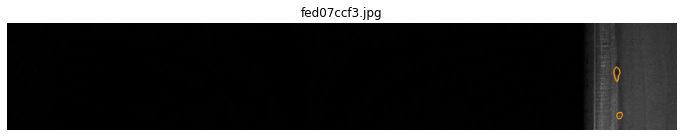

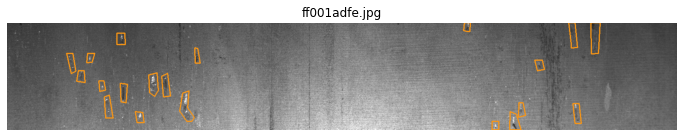

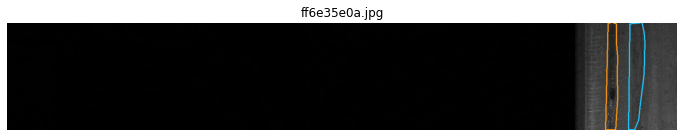

In [ ]:
# class_1 defect sumple (Orange)
for idx in idx_class_1[-3:]:
    showMasks(idx, contour=True)

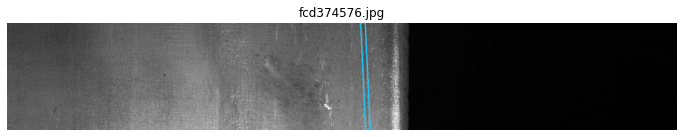

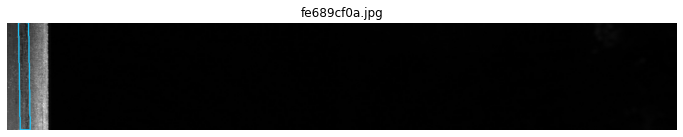

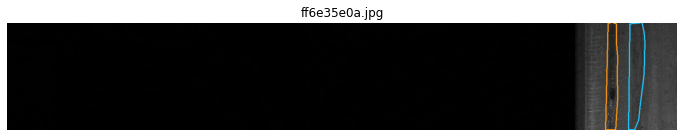

In [ ]:
# class_2 defect sumple (lightblue)
for idx in idx_class_2[-3:]:
    showMasks(idx, contour=True)

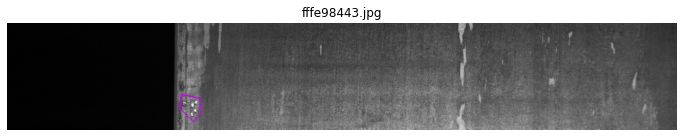

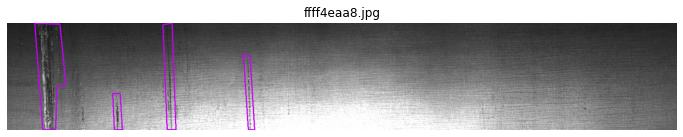

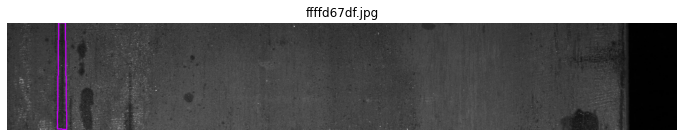

In [ ]:
# class_3 defect sumple (purple)
for idx in idx_class_3[-3:]:
    showMasks(idx, contour=True)

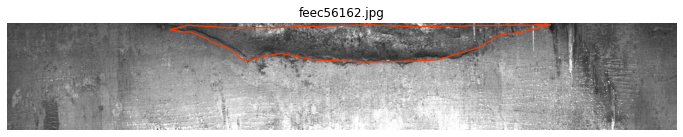

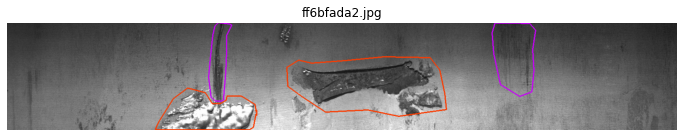

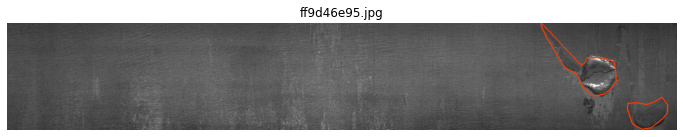

In [ ]:
# class_4 defect sumple (red)
for idx in idx_class_4[-3:]:
    showMasks(idx, contour=True)

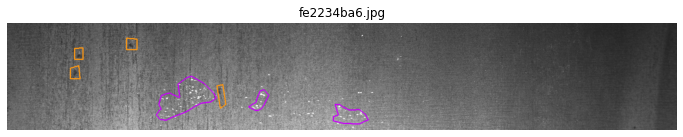

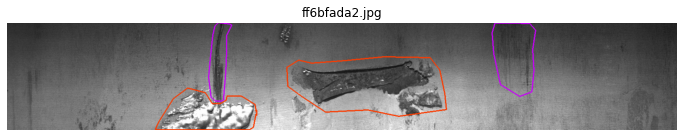

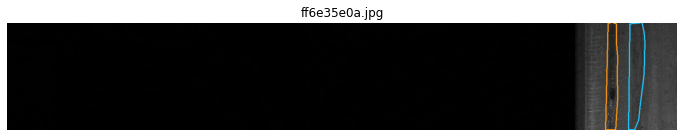

In [ ]:
# contain multi class defects
for idx in idx_class_multi[-3:]:
    showMasks(idx, contour=True)

# Data Generation

In [ ]:
##### Training conditions ##### 
batch_size = 16
epochs = 50
steps_per_epoch = 200
input_shape = (256, 1600, 1)

In [ ]:
def dataGenerator(ids, batch_size):
    Xs = []; ys = []
    while True:
        for i in ids:
            imgId, masks = createMask(i)
            img = cv2.imread(imgId, cv2.IMREAD_GRAYSCALE)
            img = img[..., np.newaxis]   # Add channel axis
            img = img / 255.             # 0～1
            masks = masks / 255.         # 0～1
            Xs.append(img); ys.append(masks)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield (X, y)

In [ ]:
train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.15)
train_gen = dataGenerator(train_ids, batch_size)
val_gen = dataGenerator(val_ids, batch_size)

X.shape: (4, 256, 1600, 1) 
y.shape: (4, 256, 1600, 4)


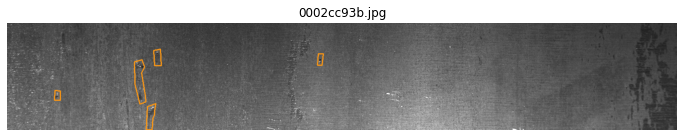

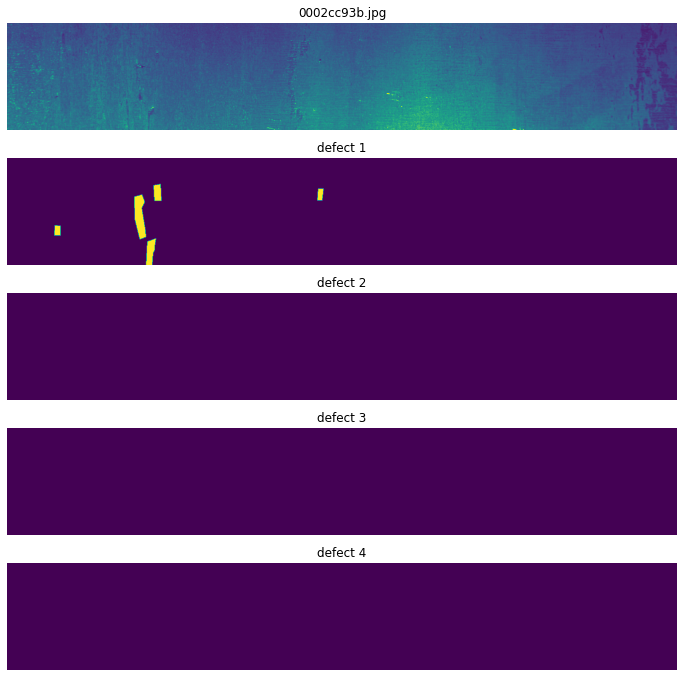

In [ ]:
# generator test
for X, y in dataGenerator(range(len(train_df)), 4):
    break

print('X.shape:',X.shape, '\ny.shape:',y.shape)

row = 0
showMasks(row, contour=True)

fig, axs = plt.subplots(5, figsize=(12,12))
axs[0].imshow(X[row,:,:,0])
axs[0].axis('off')
axs[0].set_title(train_df.iloc[row].name)
for i in range(4):
    axs[i+1].imshow(y[row,:,:,i])
    axs[i+1].set_title(f"defect {i+1}")
    axs[i+1].axis('off')

# Metrics

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

In [ ]:
def mean_iou(y_true, y_pred):
    
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)  

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall 

# Model Architectures (Only FCN trained here)

In [ ]:
def create_fcn():

    inputs = Input(input_shape)
    
    x = Conv2D(8, (3, 3), activation=None, padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    p1 = x

    x = Conv2D(16, (3, 3), activation=None, padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    p2 = x

    x = Conv2D(16, (3, 3), activation=None, padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    p3 = x

    x = Conv2D(32, (3, 3), activation=None, padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    p4 = x
 
    o = p4
    o = Conv2D(32, (5, 5), activation=None, padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    o = Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(o)

    o2 = p3
    o2 = Conv2D(64, (3, 3), activation=None, padding='same')(o2)
    o2 = BatchNormalization()(o2)
    o2 = Dropout(0.1)(o2)
    o2 = Activation('relu')(o2)

    o = concatenate([o, o2], axis=3)
    o = Conv2D(128, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Dropout(0.1)(o)
    o = Activation('relu')(o)

    o = Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same')(o)
    o = Conv2D(64, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Dropout(0.1)(o)
    o = Activation('relu')(o)

    o2 = p2
    o2 = Conv2D(32, (3, 3), activation=None, padding='same')(o2)
    o2 = BatchNormalization()(o2)
    o2 = Activation('relu')(o2)

    o = concatenate([o, o2], axis=3)
    
    o = Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)
    o = Conv2D(32, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o2 = p1
    o2 = Conv2D(16, (3, 3), activation=None, padding='same')(o2)
    o2 = BatchNormalization()(o2)
    o2 = Activation('relu')(o2)

    o = concatenate([o, o2], axis=3)
    o = Conv2D(8, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o = Conv2DTranspose(8, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)
    o = Conv2D(4, (1, 1), padding='same')(o)
    o = Activation('sigmoid')(o)
    
    model = Model(inputs=[inputs], outputs=[o])  
    optimizer = Adam()
    model.compile(optimizer, loss=dice_coef_loss, metrics=[dice_coef, precision, recall, mean_iou])
    return model

In [ ]:
def create_Unet_with_LeakyRelu():
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), padding='same') (inputs)
    c1 = LeakyReLU(alpha=0.01)(c1)
    c1 = Conv2D(8, (3, 3), padding='same') (c1)
    c1 = LeakyReLU(alpha=0.01)(c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), padding='same') (p1)
    c2 = LeakyReLU(alpha=0.01)(c2)
    c2 = Conv2D(16, (3, 3), padding='same') (c2)
    c2 = LeakyReLU(alpha=0.01)(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), padding='same') (p2)
    c3 = LeakyReLU(alpha=0.01)(c3)
    c3 = Conv2D(32, (3, 3), padding='same') (c3)
    c3 = LeakyReLU(alpha=0.01)(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), padding='same') (p3)
    c4 = LeakyReLU(alpha=0.01)(c4)
    c4 = Conv2D(64, (3, 3), padding='same') (c4)
    c4 = LeakyReLU(alpha=0.01)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), padding='same') (p4)
    c5 = LeakyReLU(alpha=0.01)(c5)
    c5 = Conv2D(64, (3, 3), padding='same') (c5)
    c5 = LeakyReLU(alpha=0.01)(c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), padding='same') (p5)
    c55 = LeakyReLU(alpha=0.01)(c55)
    c55 = Conv2D(128, (3, 3), padding='same') (c55)
    c55 = LeakyReLU(alpha=0.01)(c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), padding='same') (u6)
    c6 = LeakyReLU(alpha=0.01)(c6)
    c6 = Conv2D(64, (3, 3), padding='same') (c6)
    c6 = LeakyReLU(alpha=0.01)(c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), padding='same') (u71)
    c71 = LeakyReLU(alpha=0.01)(c71)
    c71 = Conv2D(32, (3, 3), padding='same') (c71)
    c71 = LeakyReLU(alpha=0.01)(c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c71)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), padding='same') (u7)
    c7 = LeakyReLU(alpha=0.01)(c7)
    c7 = Conv2D(32, (3, 3), padding='same') (c7)
    c7 = LeakyReLU(alpha=0.01)(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), padding='same') (u8)
    c8 = LeakyReLU(alpha=0.01)(c8)
    c8 = Conv2D(16, (3, 3), padding='same') (c8)
    c8 = LeakyReLU(alpha=0.01)(c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), padding='same') (u9)
    c9 = LeakyReLU(alpha=0.01)(c9)
    c9 = Conv2D(8, (3, 3), padding='same') (c9)
    c9 = LeakyReLU(alpha=0.01)(c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    optimizer = Adam()
    model.compile(optimizer, loss=dice_coef_loss, metrics=[dice_coef, precision, recall, mean_iou])

    return model

In [ ]:
def ResUNet():
    f = [8, 16, 32, 64, 64]
    inputs = Input(input_shape)
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)

    optimizer = Adam()
    model.compile(optimizer, loss=dice_coef_loss, metrics=[dice_coef, precision, recall, mean_iou])
    return model

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

# Training Fully Connected Network

In [ ]:
model1 = create_fcn()
# Callback
checkpoint = ModelCheckpoint("FCN.h5", monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history_FCN = model1.fit_generator(generator=train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  validation_data=val_gen,
                                  validation_steps = len(val_ids)//batch_size,
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=callbacks_list)

np.save('history_FCN.npy', history_FCN.history)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25, 20))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax[0, 0].plot(history_FCN.history['loss'], color='b', label="Training loss")
ax[0, 0].plot(history_FCN.history['val_loss'], color='r', label="validation loss")
legend = ax[0, 0].legend(loc='best', shadow=True)

ax[0, 1].plot(history_FCN.history['dice_coef'], color='b', label="Training dice_coef")
ax[0, 1].plot(history_FCN.history['val_dice_coef'], color='r',label="Validation dice_coef")
legend = ax[0, 1].legend(loc='best', shadow=True)

ax[1, 0].plot(history_FCN.history['precision'], color='b', label="FCN Training precision")
ax[1, 0].plot(history_FCN.history['val_precision'], color='r', label="FCN validation precision")
legend = ax[1, 0].legend(loc='best', shadow=True)

ax[1, 1].plot(history_FCN.history['recall'], color='b', label="FCN Training recall")
ax[1, 1].plot(history_FCN.history['val_recall'], color='r',label="FCN Validation recall")
legend = ax[1, 1].legend(loc='best', shadow=True)

ax[2, 0].plot(history_FCN.history['mean_iou'], color='b', label="FCN Training mean_iou")
ax[2, 0].plot(history_FCN.history['val_mean_iou'], color='r', label="FCN validation mean_iou")
legend = ax[2, 0].legend(loc='best', shadow=True)
plt.savefig('FCN_plots.png')